<b>Capstone Project 1 - Inferential Statistics</b>

My capstone project will explore the relationship between the features of a terrorist attack and whether or not the attack is successful. In the data storytelling section, I found some interesting patterns in how the success rate of attacks varied by region, attack type, and whether the attack was carried out by an individual or group. In preparation for attempting to build a model to predict success rate, I will now look into whether some of these patterns are statistically significant. 

First, I will look at whether there is a difference in the success rate of attacks carried out by individuals compared to attacks carried out by groups. From the codebook, the individual variable "indicates whether or not the attack was carried out by an individual or several individuals not known to be affiliated with a group or organization." The null hypothesis is that the proportion of attacks attempted by unaffiliated individuals that succeed is the same as the proportion of attacks attemped by groups that are successful. The alternative hypothesis is that the success rate for attacks attempt by unaffiliated individuals is smaller than the success rate for group attacks.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv('cleaned.csv')

In [3]:
ind_n = df[df['individual'] == 1]['individual'].count()

group_n = df[df['individual'] == 0]['individual'].count()

ind_prop = sum(df[df['individual'] == 1].success)/ind_n

group_prop = sum(df[df['individual'] == 0].success)/group_n

print("Success rate for individuals: " + str(ind_prop))
print("Success rate for groups: " + str(group_prop))
print("Number of individual attacks:", ind_n)
print("Number of group attacks:", group_n)

Success rate for individuals: 0.792105263158
Success rate for groups: 0.89944752287
Number of individual attacks: 380
Number of group attacks: 121996


In [4]:
from statsmodels.stats.proportion import proportions_ztest

successes = np.array([sum(df[df['individual'] == 1].success), sum(df[df['individual'] == 0].success)])
n_obs = (ind_n, group_n)

z, p = proportions_ztest(successes, n_obs, alternative = 'smaller')
print("z:", z,"p-value:", p)

z: -6.93688926103 p-value: 2.0041388723e-12


With a small p-value, we conclude that there is a statistically significant difference between the proportion of individual terrorist attacks that are successful and the proportion of terrorist attacks conducted by organizations that are successful. This suggests that whether an attack is carried out by an individual or group may be a useful feature for predicting the success rate of an attack. 

Now I compute the standard error for the difference in proportions, using the formula SE = $\sqrt{p_{1}(1-p_{1})/n_{1} + p_{2}(1-p_{2})/n_{2}}$. In addition, I compute the 95% confidence interval, using 1.96 as the z-value corresponding to 95% confidence.

In [6]:
SE_diff = ((ind_prop * (1 - ind_prop) / ind_n) + (group_prop * (1 - group_prop) / group_n))**0.5

print("Standard error:", SE_diff)

CI_diff = [group_prop - ind_prop - 1.96 * SE_diff, group_prop - ind_prop + 1.96 * SE_diff]
print("95% Confidence Interval for difference in proportions:", CI_diff)

Standard error: 0.0208349546912
95% Confidence Interval for difference in proportions: [0.066505748516912794, 0.14817877090650225]


Next, I will look at the relationship between region and success rate. First, let's review the plot of attack success rate by region:

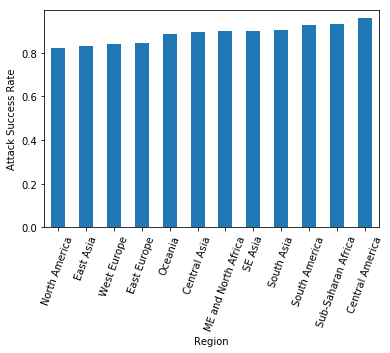

In [5]:
region_dict = {1: 'North America', 2: 'Central America', 3: 'South America', 4: 'East Asia', 5: 'SE Asia', 6: 'South Asia', 
7: 'Central Asia', 8: 'West Europe',9: 'East Europe',10: 'ME and North Africa', 
11: 'Sub-Saharan Africa', 12: 'Oceania'}

df['region_name'] = df['region'].replace(region_dict)

region_success_counts = df.groupby(['region_name'])['success'].sum()
region_counts = df.groupby(['region_name'])['success'].count()
region_success_ratio = region_success_counts.divide(region_counts)
region_success_ratio = region_success_ratio.sort_values()

_ = region_success_ratio.plot(kind='bar', rot = 70)
_ = plt.xlabel('Region')
_ = plt.ylabel('Attack Success Rate')
plt.margins(0.04)
plt.show()

I will now test whether there is a relationship between an attack's region and its success rate. Because I am testing the relationship between an observed proportion with the dependent variable being multiple categories, a chi-square test for independence is appropriate. I will test the null hypothesis that the success rate does not differ by region, with the alternative hypothesis that success rates are not the same for every region.

In [6]:
#collect observed success and failures for each region
observations = []

for i in range(1,13):
    success_count = df[df['region'] == i]['success'].sum()
    failure_count = df[df['region'] == i]['success'].count() - success_count
    counts = [success_count, failure_count]
    observations.append(counts)
    
print(observations)

[[2459, 529], [6732, 292], [13640, 1105], [555, 113], [8096, 882], [27580, 2987], [412, 48], [10510, 2007], [2958, 538], [27804, 3155], [9086, 665], [198, 25]]


In [7]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = stats.chi2_contingency(observations)
print("Chi-squared:", chi2, "p:", p)

Chi-squared: 1322.97759923 p: 4.96042586643e-277


Because the p-value is very small, we can reject the null hypothesis and conclude the region does affect the success rate. This makes it a feature of interest in our analysis. However, this test does not necessarily tell us anything about the success rate of specific regions, just that some regions have different success rates than others. 

Central America has the highest attack success rate of any region. I will compare the null hypothesis that attacks in Central America have the same success rate as attacks elsewhere with the alternative hypothesis that the success rate in Central America is greater than the success rate elsewhere.

In [8]:
df['Central_America'] = df['region'] == 2
central_n = df[df['Central_America'] == True]['success'].count()
non_central_n = df[df['Central_America'] == False]['success'].count()

central_prop = df[df['Central_America'] == True]['success'].sum()/central_n
non_central_prop = df[df['Central_America'] == False]['success'].sum()/non_central_n

print("Success rate in Central America:",central_prop)
print("Success rate outside Central America:", non_central_prop)

Success rate in Central America: 0.958428246014
Success rate outside Central America: 0.895502462029


In [9]:
successes = np.array([sum(df[df['Central_America'] == True].success), sum(df[df['Central_America'] == False].success)])
n_obs = (central_n, non_central_n)
z, p = proportions_ztest(successes, n_obs, alternative = 'larger')
print("z:", z,"p-value:", p)

z: 17.0005465992 p-value: 4.0678887249e-65


95.8% of attacks in Central America are successful, compared to 89.55% of attacks in the rest of the world. The p-value is extremely small, so we can safely reject the null hypothesis. 

South Asia has a success rate that is closer to the average. This region (which includes Afghanistan, Pakistan, and India) is populous and sees a high number of terrorist attacks. Since the rate is closer to average, I will use a two-sided test, and test the null hypothesis that attacks in South Asia have the same success rate as attacks elsewhere against the alternative hypothesis that the success rate in South Asia is different than the success rate elsewhere. 

In [10]:
df['S_Asia'] = df['region'] == 6
sa_n = df[df['S_Asia'] == True]['success'].count()
non_sa_n = df[df['S_Asia'] == False]['success'].count()

sa_prop = df[df['S_Asia'] == True]['success'].sum()/sa_n
non_sa_prop = df[df['S_Asia'] == False]['success'].sum()/non_sa_n

print("Success rate in South Asia:",sa_prop)
print("Success rate outside South Asia:", non_sa_prop)

Success rate in South Asia: 0.902280236857
Success rate outside South Asia: 0.89806010304


In [11]:
successes = np.array([sum(df[df['S_Asia'] == True].success), sum(df[df['S_Asia'] == False].success)])
n_obs = (sa_n, non_sa_n)
z, p = proportions_ztest(successes, n_obs)
print("z:", z,"p-value:", p)

z: 2.12189892756 p-value: 0.0338462265353


This p-value is fairly small, but since I have tested multiple hypotheses with the same data set, it may be advisable to use a Bonferroni correction. If we use a 5% significance level, then across the 7 hypotheses in this analysis, the p-value threshold for each test would be 0.0071. This would mean that I fail the reject the null hypothesis that attacks in South Asia have the same success rate as other attacks.  

I will now turn to the relationship between attack type and success rate. Let's review the plot of success rate by attack type:

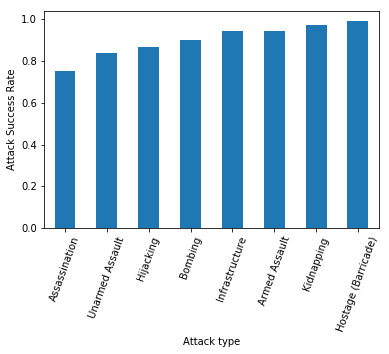

In [12]:
type_dict = {1:'Assassination', 2:'Armed Assault',
            3:'Bombing', 4:'Hijacking', 5:'Hostage (Barricade)',
             6:'Kidnapping', 7:'Infrastructure', 8:'Unarmed Assault'}

df['typename1'] = df['attacktype1'].replace(type_dict)

type_counts = df.groupby(['typename1'])['success'].count()
type_success_counts = df.groupby(['typename1'])['success'].sum()
type_success_ratio = type_success_counts.divide(type_counts)

type_success_ratio = type_success_ratio.sort_values()

_ = type_success_ratio.plot(kind='bar', rot = 70)
_ = plt.xlabel('Attack type')
_ = plt.ylabel('Attack Success Rate')
plt.show()

As before, a chi-square test for independence is appropriate for testing the null hypothesis that success rate is independent of attack type against the alternative hypothesis that attack type affects the success rate.

In [13]:
#collect observed success and failures for each attack type
type_obs = []

for i in range(1,9):
    success_count = df[df['attacktype1'] == i]['success'].sum()
    failure_count = df[df['attacktype1'] == i]['success'].count() - success_count
    counts = [success_count, failure_count]
    type_obs.append(counts)
    
chi2, p, dof, expected = stats.chi2_contingency(type_obs)
print("Chi-squared:", chi2, "p:", p)

Chi-squared: 4719.43154845 p: 0.0


This p-value is very small, so we can reject the null hypothesis that success rate is independent of attack type, making this another feature of interest in our analysis.

Because assassinations have the lowest success rate, and because they are one of the most salient and consequential types of attacks, I will now test the null hypothesis that assassination has the same success rate as other types of attacks, compared with the alternative hypothesis that assassinations have a lower success rate than other types of attacks:

In [14]:
df['Assassination'] = df['attacktype1'] == 1
assassin_n = df[df['Assassination'] == True]['success'].count()
non_assassin_n = df[df['Assassination'] == False]['success'].count()

assassin_prop = df[df['Assassination'] == True]['success'].sum()/assassin_n
non_assassin_prop = df[df['Assassination'] == False]['success'].sum()/non_assassin_n

print("Success rate for assassinations:",assassin_prop)
print("Success rate for non-assassinations:", non_assassin_prop)

Success rate for assassinations: 0.753296440527
Success rate for non-assassinations: 0.918924437762


In [15]:
successes = np.array([sum(df[df['Assassination'] == True].success), sum(df[df['Assassination'] == False].success)])
n_obs = (assassin_n, non_assassin_n)
z, p = proportions_ztest(successes, n_obs, alternative = 'smaller')
print("z:", z,"p-value:", p)

z: -62.4274637302 p-value: 0.0


This p-value is extremely small, so we can reject the null hypothesis. Hijackings appear to have a success rate that is lower than average, but that is closer to the average than assassinations. Hijackings are also a type of attack that are of high interest to the public and to safety officials. I will next evaluate the null hypothesis that hijackings have the same success rate as other attacks, compared with the alternative hypothesis that hijackings have a different success rate from non-hijacking attacks. 

In [16]:
df['Hijack'] = df['attacktype1'] == 4
hijack_n =  df[df['Hijack'] == True]['success'].count()
non_hijack_n = df[df['Hijack'] == False]['success'].count()

hijack_prop = df[df['Hijack'] == True]['success'].sum()/hijack_n
non_hijack_prop = df[df['Hijack'] == False]['success'].sum()/non_hijack_n

print("Success rate for hijackings :", hijack_prop)
print("Success rate for non-hijackings:", non_hijack_prop)

Success rate for hijackings : 0.866492146597
Success rate for non-hijackings: 0.899216354903


In [17]:
successes = np.array([sum(df[df['Hijack'] == True].success), sum(df[df['Hijack'] == False].success)])
n_obs = (hijack_n, non_hijack_n)
z, p = proportions_ztest(successes, n_obs)
print("z:", z,"p-value:", p)

z: -2.12031067418 p-value: 0.0339798540805


Again, this p-value is fairly small, but after applying the Bonferroni correction, I fail the reject the null hypothesis that hijackings have the same success rate as other attacks.  